In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import datetime

import seaborn as sns
%matplotlib inline

from nowcast import analyze
from nowcast.figures import research_VENUS
from salishsea_tools import viz_tools, tidetools

In [2]:
sns.set_style('ticks')
sns.set_context('talk')
sns.set_color_codes()

In [3]:
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
e1t = mesh.variables['e1t'][0,...]

In [4]:
def load_uv(day,mesh):
    datestr=day.strftime('%d%b%y').lower()
    datenum = day.strftime('%Y%m%d')

    f = nc.Dataset('/results/SalishSea/nowcast/{}/SalishSea_1h_{}_{}_grid_U.nc'.format(datestr, datenum,
                                                                                       datenum))
    u =f.variables['vozocrtx'][:]
    umask = mesh.variables['umask'][:]
    umask = umask +np.zeros(u.shape)
    umask = np.abs(umask-1)
    u=np.ma.masked_array(u,mask=umask)

    f = nc.Dataset('/results/SalishSea/nowcast/{}/SalishSea_1h_{}_{}_grid_V.nc'.format(datestr, datenum,
                                                                                       datenum))
    v =f.variables['vomecrty'][:]
    vmask = mesh.variables['vmask'][:]
    vmask = vmask +np.zeros(v.shape)
    vmask = np.abs(vmask-1)
    v=np.ma.masked_array(v,mask=vmask)
    
    time_counter = f.variables['time_counter']
    dates = nc.num2date(time_counter[:],time_counter.units)

    return u,v, dates

In [5]:
def load_ssh(day,mesh):
    
    datestr=day.strftime('%d%b%y').lower()
    datenum = day.strftime('%Y%m%d')


    f = nc.Dataset('/results/SalishSea/nowcast/{}/SalishSea_1h_{}_{}_grid_T.nc'.format(datestr, datenum,
                                                                                       datenum))
    ssh =f.variables['sossheig'][:]
    tmask = mesh.variables['tmask'][:,0,:,:]
    tmask = tmask +np.zeros(ssh.shape)
    tmask = np.abs(tmask-1)
    ssh=np.ma.masked_array(ssh,mask=tmask)

    return ssh

In [6]:
def baroclinic_velocities(u,v,mesh):
    
    e3u = mesh.variables['e3u'][0,:,:,:]
    umask = mesh.variables['umask'][0,:,:,:]

    depav_u= analyze.depth_average_mask(u,e3u,umask,1)
    depav_u = np.expand_dims(depav_u,1)
    ubc = u-depav_u
    del umask, e3u, depav_u
    
    e3v = mesh.variables['e3v'][0,:,:,:]
    vmask = mesh.variables['vmask'][0,:,:,:]
    
    depav_v= analyze.depth_average_mask(v,e3v,vmask,1)
    depav_v = np.expand_dims(depav_v,1)
    vbc = v-depav_v
    
    return ubc, vbc

In [7]:
day = datetime.datetime(2015,4,3)
u,v, dates  = load_uv(day,mesh)
ubc,vbc = baroclinic_velocities(u,v,mesh)

In [8]:
ssh = load_ssh(day,mesh)
dept = mesh.variables['gdept'][0,:,:,:]
dept0 =mesh.variables['gdept_0'][0,:]

In [9]:
SITES = research_VENUS.SITES['VENUS']

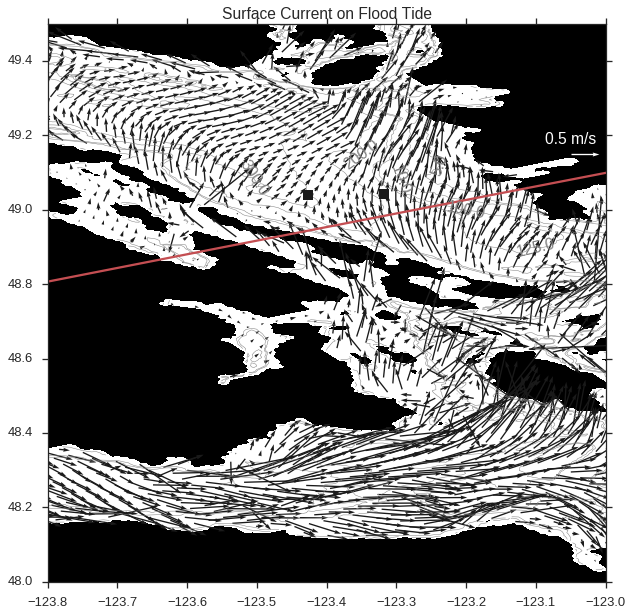

In [10]:
t=22
k=0
st=4
scale=10
u_plane,v_plane = viz_tools.unstagger(u[t,k,:,:],v[t,k,:,:])
theta = 29
theta_rad = theta * np.pi / 180
u_E = u_plane * np.cos(theta_rad) - v_plane * np.sin(theta_rad)
v_N = u_plane * np.sin(theta_rad) + v_plane * np.cos(theta_rad)

x=X[1:,1:]
y=Y[1:,1:]
j2 = 405
fig,ax = plt.subplots(1,1,figsize=(10,10))
viz_tools.plot_land_mask(ax,grid,coords='map')
ax.plot(X[j2,:],Y[j2,:], 'r-')
ax.plot(SITES['Central']['lon'],SITES['Central']['lat'],'ks')
ax.plot(SITES['East']['lon'],SITES['East']['lat'],'ks')
ax.set_xlim([-123.8,-123])
ax.set_ylim([48,49.5])
C = ax.contour(X, Y, bathy, [5, 10, 100, 125, 200, 300], colors = 'gray',linewidths=.5)
manuel_locations=[(-123.3,49.08), (-123.2,49.15),(-123.2,49),(-123.5,49.1),(-123.35,49.15), (-123.1,48.9)]
plt.clabel(C, inline=False,fmt='%.1f',ax=ax,manual=manuel_locations)
ax.get_xaxis().get_major_formatter().set_useOffset(False)

q=ax.quiver(x[::st,::st],y[::st,::st],u_E[::st,::st],v_N[::st,::st],color='k',scale=scale)
ax.quiverkey(q, -123.05, 49.15, 0.5, '0.5 m/s',color= 'w',coordinates='data', labelcolor='white')
ax.set_title('Surface Current on Flood Tide')

In [11]:
#fig.savefig('coherent_map.png',dpi=300, bbox_inches='tight')

In [12]:
def compare_beams_current(t,ubc,vbc,bathy,j,xmin=-123.55,xmax=-123.1,
                         zmin=0,zmax=300):
    
    
    ubct, vbct = viz_tools.unstagger(ubc[t,:,:,:], vbc[t,:,:,:])
    
    kebc= 0.5*(ubct**2+vbct**2)
    date = dates[t]
    fig,ax = plt.subplots(1,1,figsize=(10,5))
    clines = np.arange(0,0.051,0.001)
    xx,dd = np.meshgrid(X[j,1:], dept0)
    msh = ax.contourf(xx, dd,np.squeeze(kebc[:,j,:]),clines,cmap='hot',extend='both')
    cbar = plt.colorbar(msh,ax=ax)
    cbar.set_label(r'Baroclinic Kinetic Energy ($m^2/s^2$)')
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([zmax,zmin])
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Longitude')
    ax.set_axis_bgcolor('Burlywood')
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
        
    return fig

In [13]:
def plot_ssh(ssh,i,j,t,location):
    fig,ax = plt.subplots(1,1,figsize=(8,3))
    
    ax.plot(dates, ssh[:,j,i])
    ax.set_title(' {}'.format(dates[0].strftime('%d-%m-%Y')))
    ax.set_ylabel('Sea Surface Height (m)')

    ax.plot([dates[t],dates[t]],[-3,3],'r-')
    return fig

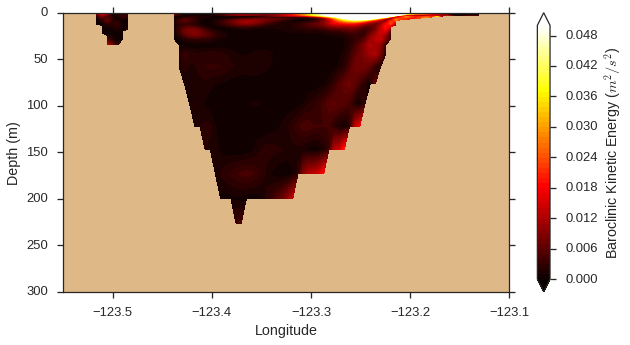

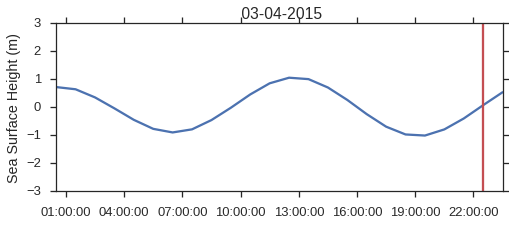

In [14]:

fig = compare_beams_current(t,ubc,vbc,bathy,j2)
#fig.savefig('beam.png',dpi=300,bbox_inches='tight')
loc='East'
fig = plot_ssh(ssh,SITES[loc]['i'],SITES[loc]['j'],t, loc)
#fig.savefig('ssh_beam.png', dpi=300,bbox_inches='tight')

In [15]:
def compare_beams_current_distance(t,ubc,vbc,bathy,j,slope,xmin=40,xmax=310,
                         zmin=0,zmax=300):
    
    
    ubct, vbct = viz_tools.unstagger(ubc[t,:,:,:], vbc[t,:,:,:])
    
    kebc= 0.5*(ubct**2+vbct**2)
    date = dates[t]
    fig,ax = plt.subplots(1,1,figsize=(10,5))
    clines = np.arange(0,0.051,0.001)
    xx,dd = np.meshgrid((xmax-np.arange(kebc.shape[-1]))*e1t[j,1:],dept0)
    line = xx[0,:]*slope -7500*slope
    msh = ax.contourf(xx/1000, dd,np.squeeze(kebc[:,j,:]),clines,cmap='hot',extend='both')
    ax.plot(xx[0,:]/1000, line, 'w--')
    cbar = plt.colorbar(msh,ax=ax)
    cbar.set_label(r'Baroclinic Kinetic Energy ($m^2/s^2$)')
    ax.set_xlim([xmin,0])
    ax.set_ylim([zmax,zmin])
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Distance (km)')
    ax.set_axis_bgcolor('Burlywood')
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
        
    return fig

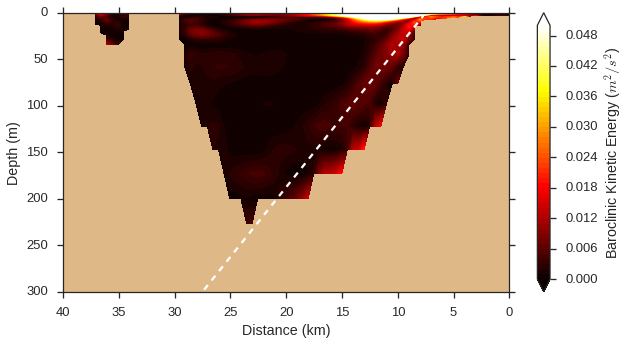

In [16]:
slope = 0.015
fig = compare_beams_current_distance(t,ubc,vbc,bathy,j2,slope)

In [17]:
#fig.savefig('beams_slope.png', dpi=300)